In [1]:
train_dataset_dir = '/home/noa_glaser//proj/data/train-frames/train'
val_dataset_dir = '/home/noa_glaser/proj/data/train-frames/val'
audio_dataset_dir = '/home/noa_glaser/proj/data/train-audio'
label_dataset_dir = train_dataset_dir
exp_name = 'ResNet34_ONLY_experiment_L2_dropout' # roughly 3K videos
num_classes = 5 
num_partition = 10
batch_size = 32

In [2]:
# -*- coding: utf-8 -*- 

from __future__ import print_function, division

import pickle
import sys
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import time
import copy
import shutil

## first, get the Images (path) and their labels (five personality traits)

In [3]:
def _get_imgname_and_moviename_and_labels(dataset_dir):
    """Returns a list of 
filenames and inferred class names.
    Args:
    dataset_dir: A directory containing a set of subdirectories representing
      class names. Each subdirectory should contain PNG or JPG encoded images.
    Returns:
    A list of image file paths, relative to `dataset_dir` and the list of
    subdirectories, representing class names.
    """
   
    print("processing dataset: "+ dataset_dir)
    img_names = [] 
    movies= []
    labels = []

    annotaion_filename = dataset_dir + "/annotation_training.pkl"
    
    with open(annotaion_filename, 'rb') as f:
        label_dicts = pickle.load(f, encoding='latin1') 

    for movie in os.listdir(dataset_dir):
        fileEnding ='_50uniform' #TODO: figure out how to make more general
        if fileEnding not in movie: continue #skip non-movie files
        raw_moviename = movie.replace(fileEnding,'.mp4')
        big_five = [label_dicts['extraversion'][raw_moviename], 
                    label_dicts['neuroticism'][raw_moviename],
                    label_dicts['agreeableness'][raw_moviename],
                    label_dicts['conscientiousness'][raw_moviename],
                    label_dicts['openness'][raw_moviename]
                    #label_dicts['interview'][raw_moviename]
                    ]
        
        movie_path = os.path.join(dataset_dir, movie)
        for img in  os.listdir(movie_path):
            
            path = os.path.join(movie_path, img)
            if path == os.path.join(dataset_dir,'bt-ev53zZWE.004_5fps/frame51.jpg'): # this is a bad 
                continue
            img_names.append(path)
            movies.append(movie)
            labels.append(big_five)
        

    return np.array(img_names), np.array(labels), np.array(movies)

## use this if we have seperated train/val dataset

In [4]:
training_filenames, train_labels, train_movies = _get_imgname_and_moviename_and_labels( train_dataset_dir)  
validation_filenames, val_labels, val_movies = _get_imgname_and_moviename_and_labels(val_dataset_dir)  

processing dataset: /home/noa_glaser//proj/data/train-frames/train
processing dataset: /home/noa_glaser/proj/data/train-frames/val


## Data Loader. Data is normalized before feeding into model (as required by the pretrained model)

In [5]:
def default_loader(path):
	return Image.open(path).convert('RGB')

class Visual_ONLY(data.Dataset):
    def __init__(self,root,split,imgs,movies,labels,transform=None, target_transform=None,
                 loader=default_loader):
        
        #classes, class_to_idx = find_classes(root)
        #imgs = make_dataset(root, class_to_idx)
        if len(imgs) == 0:
            raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                               "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))
        self.split = split
        self.root = root
        self.imgs = imgs
        self.movies = movies
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.mean = np.array(self.loader(self.imgs[0]))

    def __getitem__(self, index):
        path, target = self.imgs[index], self.labels[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        
        return img, target

    def __len__(self):
        return len(self.imgs)
    
        
    

In [6]:
from torchvision import  transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(256),
        transforms.RandomCrop(256),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
dsets = {}
dsets['train'] = Visual_ONLY(train_dataset_dir,'train',training_filenames,train_movies,train_labels,transform=data_transforms['train'] )
dsets['val'] = Visual_ONLY(val_dataset_dir,'val',validation_filenames,val_movies,val_labels,transform=data_transforms['val'] )

dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=32,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_sizes

{'train': 48000, 'val': 12000}

##  Some dataset examples (each batch is 16)

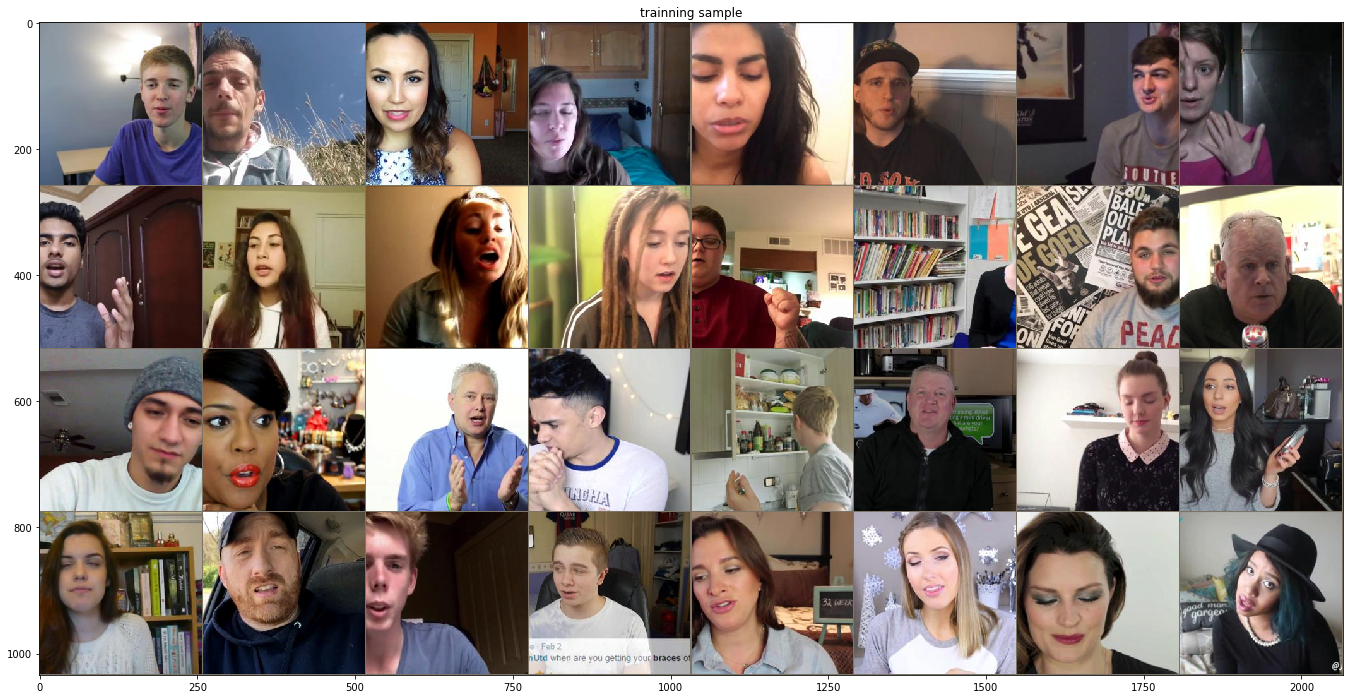

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


train_imgsamples,train_labelsample = next(iter(dset_loaders['train']))

train_unflattened_sample = train_imgsamples.view(-1,3,256,256)
# Make a grid from batch
plt.figure( figsize=(8*3,4*3))
out = torchvision.utils.make_grid(train_unflattened_sample,nrow=8)
imshow(out, title='trainning sample')
#plt.savefig('train_exp.png', bbox_inches='tight')


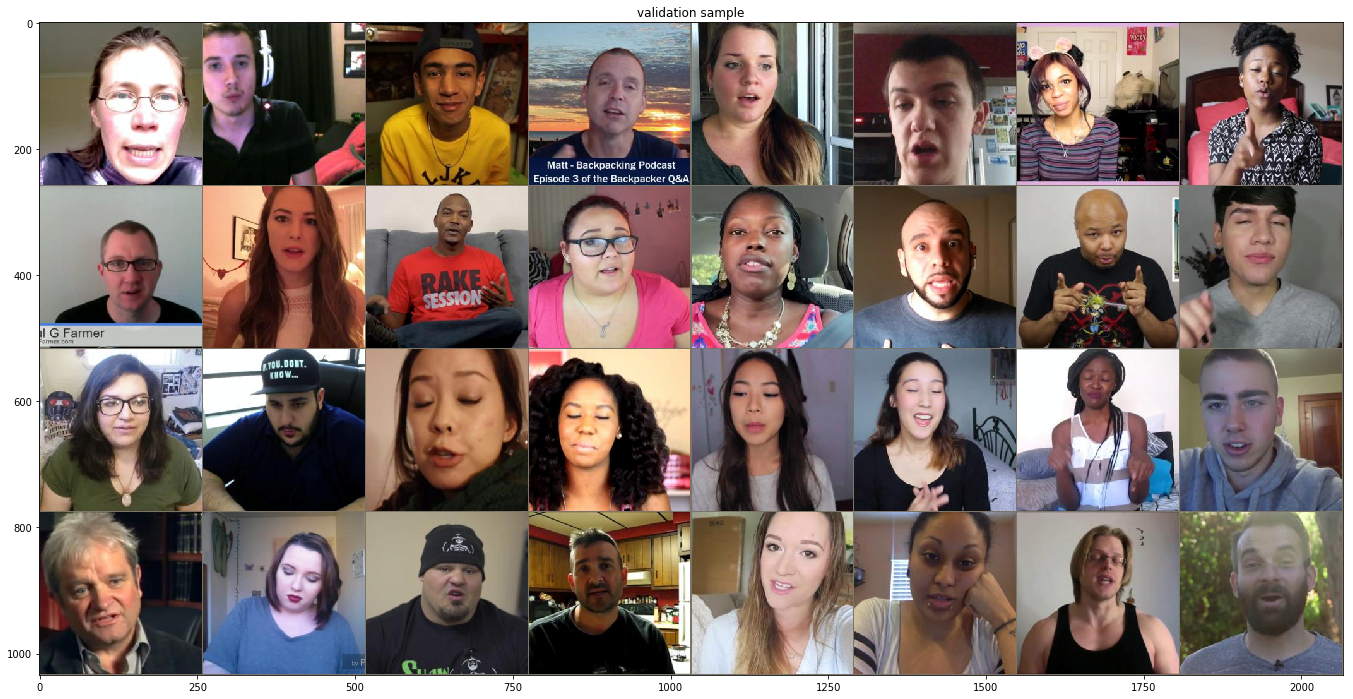

In [8]:

val_imgsamples,val_labelsample = next(iter(dset_loaders['val']))

val_unflattened_sample = val_imgsamples.view(-1,3,256,256)
# Make a grid from batch
plt.figure( figsize=(8*3,4*3))
out2 = torchvision.utils.make_grid(val_unflattened_sample,nrow=8)
imshow(out2, title='validation sample')
#plt.savefig('train_exp.png', bbox_inches='tight')


#  MODEL

In [7]:
class Resnet34_only(nn.Module):
   
    NUM_VID_FEATURES = 128
    NUM_PARTITIONS = 10
    NUM_CLASS = 5
    NUM_IMG_SIZE = 256
    NUM_CHANNEL = 3
    
    def __init__(self):        
        super(Resnet34_only, self).__init__()
        self.videoBranch = self._createVideoBranch()
        self.droupout = nn.Dropout(p=0.35)
        self.fc = nn.Linear(self.NUM_VID_FEATURES,self.NUM_CLASS)
        self.sigmoid = nn.Sigmoid()
        
    def _createVideoBranch(self):
        model_pretrained = torchvision.models.resnet34(pretrained=True)
        # All of the parameters are freezed, not to change (newly constructed layers' params won't be influenced)
        for param in model_pretrained.parameters():
            param.requires_grad = False   
        model_pretrained.fc = nn.Linear(model_pretrained.fc.in_features, self.NUM_VID_FEATURES)
        return model_pretrained
    
    def forward(self, x):
        x = self.videoBranch(x)
        x = self.droupout(x)
        x = self.fc(x)
        x = self.sigmoid(x) #(N,5)
        return x   

### some helper functions

In [8]:
# some gpu configs
use_gpu = True
gpu_dtype = torch.cuda.FloatTensor

def get_learnable_params(m,verbose = 0):
    ret = []
    for l in m.parameters():
        if l.requires_grad == True:
            ret.append(l)
            if verbose == 1:
                print (l.size())
            if verbose == 2:
                print (l)
    return ret

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "resnet_for_rnn/%s/"%(exp_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'resnet_for_rnn/%s/'%(exp_name) + 'model_best.pth.tar')

def log_value(to_log, log_path = './log_'+ exp_name + '.txt'):
    log_file = open(log_path, 'a+')
    log_file.write(to_log)
    log_file.close()
    

## Train The Model

## train and eval functions

In [9]:
log_freq = 60

def train(train_loader, model, criterion, optimizer, epoch) :
    batch_time = AverageMeter()
    losses = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, data in enumerate(train_loader):
        # measure data loading time
        input_image, target = data
        input_image_var,target_var = Variable(input_image.type(gpu_dtype)),Variable(target.type(gpu_dtype))
        # compute output
        output = model(input_image_var)
        loss = criterion(output, target_var)
        # measure accuracy and record loss
        losses.update(loss.data[0], input_image.size(0))
        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if i % log_freq == 0:
            to_log = 'Epoch: [{0}][{1}/{2}]\t Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t Loss {loss.val:f} ({loss.avg:f})\n'.format(
                   epoch, i, len(train_loader), batch_time=batch_time, loss=losses)
            log_value(to_log)
            print(to_log)
            
       
    return losses.avg

def validate(val_loader, model, criterion, epoch):
    """Perform validation on the validation set"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, data in enumerate(val_loader):
        input_image, target = data
        input_image_var,target_var = Variable(input_image.type(gpu_dtype)),Variable(target.type(gpu_dtype))
        # compute output
        output = model(input_image_var)
        loss = criterion(output, target_var)
        # measure accuracy and record loss
        losses.update(loss.data[0], input_image.size(0))
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if i %  log_freq == 0:
            to_log = 'Val/Test: [{0}/{1}]\t Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t Loss {loss.val:f} ({loss.avg:f})\n'.format(
                      i, len(val_loader), batch_time=batch_time, loss=losses)
            log_value(to_log)
            print(to_log)
                        
    return losses.avg, output,input_image,target

# Train Script

In [10]:
# TODO: for larger dataset, consider a step function or exponentialdecay
def lr_scheduler(optimizer, epoch):
    return optimizer

In [11]:

# can retriecve these latest val results for plotting
val_preds,val_imgs,val_targets = None,None,None



def train_model(startModel=None, startEpoch=0, numEpochs=10):    
    model = Resnet34_only().type(gpu_dtype)
    #del model_base
    #  changed to l1 loss to reflect competition 
    criterion = nn.MSELoss().type(gpu_dtype)

    #only optimizing the new_fc layer parameters, other pretrained weights are freezed¶
    optimizer  = optim.SGD(get_learnable_params(model),lr=5e-2, momentum=0.9,weight_decay=5e-4)

    best_loss = 1000 # will get overwritten
    
    if(startModel != None):
        print("=> loading checkpoint '{}'".format(startModel))
        checkpoint = torch.load(startModel)
        startEpoch = checkpoint['epoch']
        best_loss = checkpoint['best_loss'] # for now because old loss is stale
        model.load_state_dict(checkpoint['state_dict'])
        # todo - figure out why not working
        #optimizer.load_state_dict(checkpoint['optimizer'])
        # print(optimizer.param_groups)
        
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(startModel, checkpoint['epoch']))
    #else:
        # benchmark the model 
        #best_loss = validate(dset_loaders['val'], model, criterion, startEpoch)
        
    bestModel = model

    for epoch in range(startEpoch,startEpoch+numEpochs):
        # train for one epoch
        train_loss = train(dset_loaders['train'], model, criterion, optimizer, epoch)

        # evaluate on validation set
        val_loss,val_preds,val_imgs,val_targets = validate(dset_loaders['val'], model, criterion, epoch)

        # log 
        log_value('Epoch: [{0}]\t Train Loss: {train_loss:f}  \t Val Loss: {val_loss:f}\n'.format(epoch,\
                                        train_loss=train_loss,val_loss=val_loss),'./%s_epoch_log.txt'%exp_name)
        print('Epoch: [{0}]\t Train Loss: {train_loss:f}  \t Val Loss: {val_loss:f}\n'.format(epoch,\
                    train_loss=train_loss,val_loss=val_loss))

        # remember best loss and save checkpoint
        is_best = val_loss <= best_loss
        best_loss = min(val_loss, best_loss)
        save_checkpoint({
            'epoch': epoch + 1,
            'arch': 'resnet34_only',
            'state_dict': model.state_dict(),
            'best_loss': best_loss,
            'optimizer' : optimizer.state_dict(),
        }, is_best)
        print (is_best, best_loss)

    print ('Best Loss: ', best_loss)

## Start to train a new model run this line

In [ ]:
train_model(startModel=None, startEpoch=0, numEpochs=1)

## Train from the latest model checpoint run this cell, specify startepoch

In [ ]:

startModel='./resnet_for_rnn/ResNet34_ONLY_experiment_L2_dropout/checkpoint.pth.tar'
train_model(startModel=startModel, startEpoch= 54 , numEpochs=200)

# note, at epoch 34, upped dropout to .3 

=> loading checkpoint './resnet_for_rnn/ResNet34_ONLY_experiment_L2_dropout/checkpoint.pth.tar'
=> loaded checkpoint './resnet_for_rnn/ResNet34_ONLY_experiment_L2_dropout/checkpoint.pth.tar' (epoch 52)
Epoch: [52][0/1500]	 Time 1.186 (1.186)	 Loss 0.018219 (0.018219)

Epoch: [52][60/1500]	 Time 0.285 (0.298)	 Loss 0.017009 (0.017405)

Epoch: [52][120/1500]	 Time 0.287 (0.292)	 Loss 0.017292 (0.017488)

Epoch: [52][180/1500]	 Time 0.286 (0.290)	 Loss 0.020490 (0.017467)

Epoch: [52][240/1500]	 Time 0.285 (0.290)	 Loss 0.019085 (0.017552)


# visualize the pred and targets and images of the latest val batch

In [ ]:
    
val_pred = (val_preds.data).cpu().numpy()
val_gt = (Variable(val_targets).data).cpu().numpy()
# select a video in batch to see: idx can be 0-7
idx = 7
plt.subplot(1,2,1)
plt.bar(np.arange(5),val_gt[idx])
plt.xticks(np.arange(5),['e','n','a','c','o'])
plt.gca().set_ylim([0.0,1.0])
plt.subplot(1,2,2)
plt.bar(np.arange(5),val_pred[idx])
plt.xticks(np.arange(5),['e','n','a','c','o'])
plt.gca().set_ylim([0.0,1.0])
plt.show()
val_unflattened_sample = val_imgs.view(-1,3,256,256)
# Make a grid from batch
plt.figure( figsize=(30, 3))
out = torchvision.utils.make_grid(val_unflattened_sample[idx*10:idx*10+10],nrow=10)
imshow(out, title='trainning sample')
#plt.savefig('train_exp.png', bbox_inches='tight')